## CAMB


In [3]:
from halos import Catalog, Cosmo
from astropy.cosmology import LambdaCDM, z_at_value
import matplotlib.pyplot as plt
import healpy as hp
import numpy as np
import astropy.units as u
from scipy.interpolate import make_interp_spline

import camb
from camb.sources import GaussianSourceWindow, SplinedSourceWindow
from camb import model, initialpower


h_Hubble = 0.67

%matplotlib inline

In [5]:
cosmo = Cosmo()
nside = 4096
npix = hp.nside2npix(nside)
snapshot_numbers = range(48, 63)

/opt/miniconda3/lib/python3.12/site-packages/scipy/optimize/_optimize.py:2972: RuntimeWarning: overflow encountered in scalar divide
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom


In [6]:
mass_inf = 0

halo_map = np.zeros(npix)
z_shell = []
halos_number = []
halos_redshift = []
diff = []
for snapshot in snapshot_numbers:
    print(f"Snapshot n: {snapshot}")
    catalog = Catalog(snapshot)
    print(f"Numer of halos: {catalog.get_n_halos()}")
    catalog_selection = catalog.select_mass_above(mass_inf)
    print(f"Number of halos (M>{mass_inf}): {catalog_selection.get_n_halos()} \n")
    del catalog
    
    catalog_selection.compute_pixel(nside)
    halo_map[catalog_selection.pixel] += 1

    catalog_selection.compute_redshift()
    halos_redshift.append(catalog_selection.halos_redshift)
    
    z_shell.append(catalog_selection.redshift)
    halos_number.append(catalog_selection.get_n_halos())
    diff.append(catalog_selection.z_end - catalog_selection.z_start)

halos_redshift = np.concatenate(halos_redshift)

bin_edges = np.linspace(0, 0.485510, 21)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])  # Centri dei bin
halo_counts, _ = np.histogram(halos_redshift, bins=bin_edges)  

# Normalizza
bin_widths = np.diff(bin_edges)
halos_density = halo_counts / bin_widths

Snapshot n: 48
Reading AllSkyMock_snap_048_0.bin0...
Reading AllSkyMock_snap_048_1.bin0...
Reading AllSkyMock_snap_048_2.bin0...
Reading AllSkyMock_snap_048_3.bin0...
Numer of halos: 4400733
Number of halos (M>0): 4400733 

Snapshot n: 49
Reading AllSkyMock_snap_049_0.bin0...
Reading AllSkyMock_snap_049_1.bin0...
Reading AllSkyMock_snap_049_2.bin0...
Reading AllSkyMock_snap_049_3.bin0...
Numer of halos: 3656099
Number of halos (M>0): 3656099 

Snapshot n: 50
Reading AllSkyMock_snap_050_0.bin0...
Reading AllSkyMock_snap_050_1.bin0...
Reading AllSkyMock_snap_050_2.bin0...
Reading AllSkyMock_snap_050_3.bin0...
Numer of halos: 2272139
Number of halos (M>0): 2272139 

Snapshot n: 51
Reading AllSkyMock_snap_051_0.bin0...
Reading AllSkyMock_snap_051_1.bin0...
Reading AllSkyMock_snap_051_2.bin0...
Reading AllSkyMock_snap_051_3.bin0...
Numer of halos: 1898259
Number of halos (M>0): 1898259 

Snapshot n: 52
Reading AllSkyMock_snap_052_0.bin0...
Reading AllSkyMock_snap_052_1.bin0...
Reading AllSk

In [4]:
cmb_map_sum = np.zeros(npix)
for snapshot in snapshot_numbers:
    
    map_file = f'KappaMap_snap_{snapshot:03d}.DM.seed_100672.fits'
    print(f"Reading {map_file}")
    
    z_l = cosmo.from_snapshot_get(snapshot, 'z')
    cmb_weight = cosmo.from_snapshot_get(snapshot, 'cmb_weight')
    cmb_map = cosmo.lens_weight(z_l, 0.485510) * (1/cmb_weight) * hp.read_map(map_file)
    
    cmb_map_downgraded = hp.ud_grade(cmb_map, nside)
    cmb_map_sum += cmb_map_downgraded


Reading KappaMap_snap_048.DM.seed_100672.fits
Reading KappaMap_snap_049.DM.seed_100672.fits
Reading KappaMap_snap_050.DM.seed_100672.fits
Reading KappaMap_snap_051.DM.seed_100672.fits
Reading KappaMap_snap_052.DM.seed_100672.fits
Reading KappaMap_snap_053.DM.seed_100672.fits
Reading KappaMap_snap_054.DM.seed_100672.fits
Reading KappaMap_snap_055.DM.seed_100672.fits
Reading KappaMap_snap_056.DM.seed_100672.fits
Reading KappaMap_snap_057.DM.seed_100672.fits
Reading KappaMap_snap_058.DM.seed_100672.fits
Reading KappaMap_snap_059.DM.seed_100672.fits
Reading KappaMap_snap_060.DM.seed_100672.fits
Reading KappaMap_snap_061.DM.seed_100672.fits
Reading KappaMap_snap_062.DM.seed_100672.fits


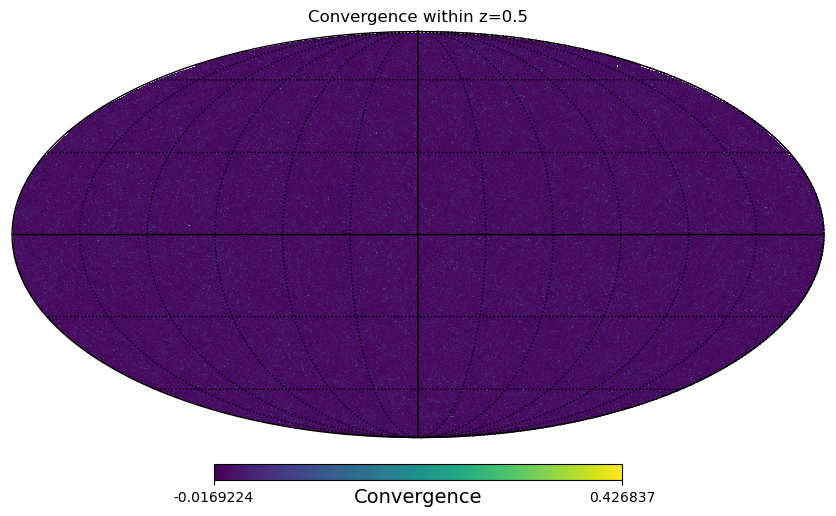

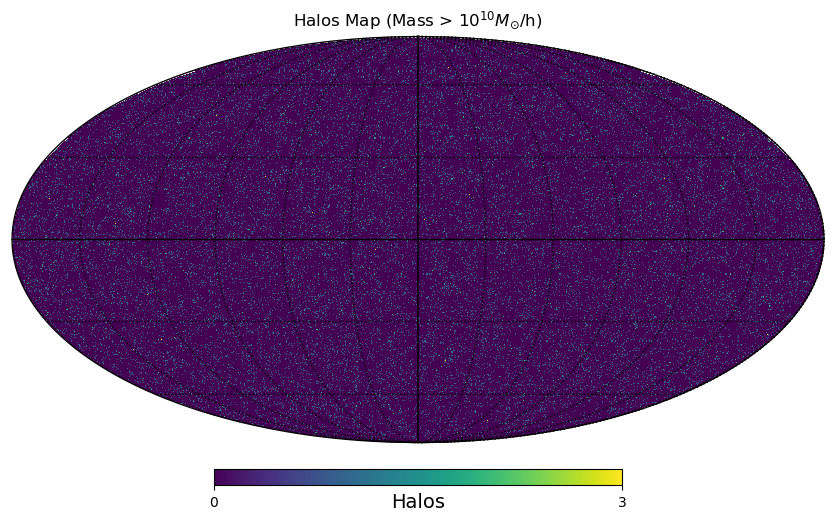

In [5]:
hp.mollview(cmb_map_sum, title="Convergence within z=0.5", unit="Convergence")
hp.graticule()
plt.show()

# Display the halo map
hp.mollview(halo_map, title=r'Halos Map (Mass > $10^{10} M_{\odot}$/h)', unit='Halos')
hp.graticule()
plt.show()

In [6]:
#------------------ CROSS CORRELATION ----------------------
mean_halo_count = np.mean(halo_map)
halo_contrast = (halo_map - mean_halo_count) / mean_halo_count
cross_correlation_kappa = hp.anafast(halo_contrast, cmb_map_sum, lmax=3500)
cross_correlation_kappa_kappa = hp.anafast(cmb_map_sum, cmb_map_sum, lmax=3500)
cross_correlation_halos_halos = hp.anafast(halo_contrast, halo_contrast, lmax=3500)

In [11]:
import pickle
with open("halo_data_4096.pkl", "wb") as f:
    pickle.dump({
        "cross_correlation_kappa": cross_correlation_kappa,
        "cross_correlation_kappa_kappa": cross_correlation_kappa_kappa,
        "cross_correlation_halos_halos": cross_correlation_halos_halos
    }, f)

In [1]:
import pickle
# Riapri il file e leggi i dati
with open("halo_data_4096.pkl", "rb") as f:
    data = pickle.load(f)

# Estrai le variabili
cross_correlation_kappa = data["cross_correlation_kappa"]
cross_correlation_kappa_kappa = data["cross_correlation_kappa_kappa"]
cross_correlation_halos_halos = data["cross_correlation_halos_halos"]


In [2]:
# Simulation
OmegaCDM = 0.27
OmegaBr = 0.05
OmegaNeu = 0.00
OmegaLambda = 0.68
h_Hubble = 0.67
OmegaR0 = 9.2865e-5  # Densità di radiazione
Omega0 = OmegaCDM + OmegaBr  # Densità totale della materia
H0 = h_Hubble * 100  # km/s/Mpc

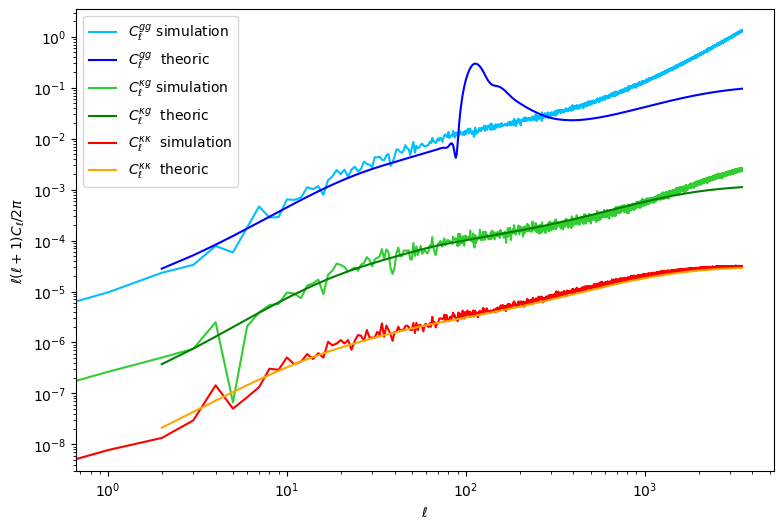

In [7]:
lmax=3500
pars = camb.CAMBparams()
pars.set_cosmology(H0=67, ombh2=OmegaBr * h_Hubble ** 2, omch2= OmegaCDM * h_Hubble ** 2)
pars.InitPower.set_params(As=2e-9, ns=0.965)
pars.set_for_lmax(lmax, lens_potential_accuracy=1)
#set Want_CMB to true if you also want CMB spectra or correlations
pars.Want_CMB = False 
#NonLinear_both or NonLinear_lens will use non-linear corrections
pars.NonLinear = model.NonLinear_both

#Set up W(z) window functions, later labelled W1, W2. Gaussian here.
pars.SourceWindows = [
    #SplinedSourceWindow(z = bin_centers, W = halos_density, source_type='counts'),
    SplinedSourceWindow(z = z_shell[::-1], W = np.array(halos_number[::-1])/ np.array(diff[::-1]), source_type='counts'),
    GaussianSourceWindow(redshift=0.485510, source_type='lensing', sigma=1e-5)]

results = camb.get_results(pars)
cls = results.get_source_cls_dict()

l = np.arange(len(cross_correlation_kappa))
ls=  np.arange(2, lmax+1)

plt.figure(figsize=(9, 6))
plt.plot(l, cross_correlation_halos_halos * l * (l + 1)/(2 * np.pi), label = r'$C_\ell^{gg}$ simulation', color='deepskyblue')
plt.loglog(ls, cls['W1xW1'][2:lmax+1], label = r'$C_\ell^{gg}$  theoric', color='blue')
plt.plot(l, cross_correlation_kappa * l * (l + 1)/(2 * np.pi), label=r'$C_\ell^{\kappa g}$ simulation', color='limegreen')
plt.loglog(ls, cls['W1xW2'][2:lmax+1], label = r'$C_\ell^{\kappa g}$  theoric', color='green')
plt.plot(l, cross_correlation_kappa_kappa * l * (l + 1)/(2 * np.pi), label = r'$C_\ell^{\kappa \kappa}$  simulation', color='red')
plt.loglog(ls, cls['W2xW2'][2:lmax+1], label = r'$C_\ell^{\kappa \kappa}$  theoric', color='orange')


plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell(\ell+1)C_\ell/2\pi$')
plt.legend();
plt.show()